<a href="https://colab.research.google.com/github/Mohamed28112003/Forum-Discussions-Categorization/blob/main/Forum_Discussions_Categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Libraries**

In [ ]:
# !pip install --upgrade tensorflow


In [ ]:
!pip install contractions
!pip install gensim
!pip install nlpaug


In [ ]:
# Standard Python libraries
import os
import re
import string
import requests
from zipfile import ZipFile
from collections import Counter

# Scientific and Data Analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure necessary NLTK downloads (only need to run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.data.path.append('/usr/local/share/nltk_data')

# Machine Learning libraries
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.metrics as metrics

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    Bidirectional, BatchNormalization
)
from tensorflow.keras.models import Model


from tensorflow.keras.layers import (
    Input, Embedding, SpatialDropout1D,
    Bidirectional, LSTM, GRU,
    GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Dense
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# PyTorch libraries (if needed)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Transformers and Sentence Embeddings
from transformers import BertTokenizer, TFBertModel, BertConfig, BertModel
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec

from tensorflow.keras import regularizers

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras
# Google Colab utilities (if running in Colab)
from google.colab import files


from tensorflow.keras import regularizers
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **Data Exploration**

In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
df.head()

,SampleID,Discussion,Category
0,1,"Without sitting down and doing it manually, yo...",Sports
1,2,All your Search ends with this link.,STEM
2,3,"No, the program you're using is made to be com...",STEM
3,4,Mike Woicik\n\nThe correct answer is: Mike Woi...,Sports
4,5,"No, but not because of why you might think. Wh...",Politics


In [ ]:
df.shape

(24989, 3)

In [ ]:
df["Category"].value_counts()

,count
Category,
STEM,5530
Market & Economy,5530
Sports,5529
Politics,4200
Media,4200


In [ ]:
print(df.dtypes)

SampleID       int64
Discussion    object
Category      object
dtype: object


## **Data Preprocessing**

#### **Checking Nulls**

In [ ]:
df.isnull().sum()

,0
SampleID,0
Discussion,343
Category,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

,0
SampleID,0
Discussion,0
Category,0


#### **Data Cleaning**

**Handling contractions and abbreviations**

In [ ]:
def expand_contractions(text):
    return contractions.fix(text)

In [ ]:
abbreviations = {
    "asap": "as soon as possible",
    "lol": "laughing out loud",
    "ttyl": "talk to you later",
    "omg": "oh my god",
    "brb": "be right back",
    "idk": "i don't know",
    "btw": "by the way",
    "fyi": "for your information",
    "smh": "shaking my head",
}

def expand_abbreviations(text):
    words = text.split()
    expanded_words = [abbreviations.get(word.lower(), word) for word in words]
    return ' '.join(expanded_words)

In [ ]:
df['Discussion'] = df['Discussion'].apply(expand_contractions)

In [ ]:
df['Discussion'] = df['Discussion'].apply(expand_abbreviations)

**Lower Case**

In [ ]:
df['Discussion'] = df['Discussion'].str.strip().str.lower()
df['Category'] = df['Category'].str.strip().str.lower()

In [ ]:
def normalize_repeated_chars(text):
  return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
df['Discussion'] = df['Discussion'].apply(normalize_repeated_chars)

**Removing punctuations**

In [ ]:
df['Discussion'] = df['Discussion'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['Category'] = df['Category'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

**Drop small lengths**

In [ ]:
min_length = 20
df = df[df['Discussion'].str.len() > min_length]

**Handling Mismatches**

In [ ]:
mismatched_discussions = (
    df[df.duplicated(subset="Discussion", keep=False)]
    .groupby("Discussion")
    .filter(lambda x: x["Category"].nunique() > 1 and not x['Discussion'].str.isnumeric().all()))

In [ ]:
print(len(mismatched_discussions))

40


In [ ]:
mismatched_discussions.head(40)

,SampleID,Discussion,Category
133,134,htpwjimyrcomsearchistoryphp,market economy
425,426,it apears that the question period has expired...,market economy
1559,1560,the rule as always is to stay away from those ...,stem
2371,2372,it apears that the question period has expired...,market economy
2418,2419,it apears that the question period has expired...,market economy
3091,3092,htpwjimyrcomsearchistoryphp,stem
3101,3102,htpwjimyrcomsearchistoryphp,market economy
3103,3104,the rule as always is to stay away from those ...,market economy
3631,3632,it apears that the question period has expired...,market economy
4278,4279,hey just bringing this old question up for a vote,market economy


In [ ]:
def replace_with_media(group):
    group['Category'] = 'media'
    return group

updated_mismatched_discussions = mismatched_discussions.groupby("Discussion").apply(replace_with_media)

updated_mismatched_discussions = updated_mismatched_discussions.reset_index(drop=True)

df = df.merge(updated_mismatched_discussions[['Discussion', 'Category']], on='Discussion', how='left', suffixes=('', '_updated'))

df['Category'] = df['Category_updated'].fillna(df['Category'])

df.drop(columns=['Category_updated'], inplace=True)

<ipython-input-273-5cca4b8b4ef5>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  updated_mismatched_discussions = mismatched_discussions.groupby("Discussion").apply(replace_with_media)


**Replacing all categories of numeric rows to mode**

In [ ]:
df.loc[df['Discussion'].str.match(r'^\d+$', na=False), 'Category'] = 'sports'

In [ ]:
print(df[df['Discussion'] == '17'])

Empty DataFrame
Columns: [SampleID, Discussion, Category]
Index: []


**Handling Duplicates**

In [ ]:
duplicates = df[df.duplicated(subset=["Discussion", "Category"], keep=False)]

In [ ]:
print(len(duplicates))

306


In [ ]:
df = df.drop_duplicates(subset=["Discussion", "Category"], keep='first')

In [ ]:
print(df.duplicated(subset=["Discussion", "Category"]).sum())

0


**Ensure no mismatches remain**

In [ ]:
mismatched_discussions_after = (
    df[df.duplicated(subset="Discussion", keep=False)]
    .groupby("Discussion")
    .filter(lambda x: x["Category"].nunique() > 1 and not x['Discussion'].str.isnumeric().all())
)

if mismatched_discussions_after.empty:
    print("No mismatches remain")
else:
    print("Mismatches still exist")
    print(mismatched_discussions_after)

No mismatches remain


#### **Encoding Category**

In [ ]:
print(df['Category'].unique())

['sports' 'stem' 'politics' 'media' 'market  economy']


In [ ]:
category_mapping = {
    'politics': 0,
    'sports': 1,
    'media': 2,
    'market  economy': 3,
    'stem': 4
}

df['Category'] = df['Category'].map(category_mapping)

<ipython-input-282-23027b405aec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'] = df['Category'].map(category_mapping)


In [ ]:
print(df['Category'].unique())

[1 4 0 2 3]


#### **Lemmatization & Removing Stop Words**

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):

    tokens = nltk.word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [ ]:
df['Discussion'] = df['Discussion'].apply(preprocess_text)

In [ ]:
df['Discussion'].head()

,Discussion
0,without siting manualy might try scheduling so...
1,al search end link
2,program using made compatible dvdrom drive pos...
3,mike woiciknnthe corect answer mike woicik sup...
4,might think profile something tend mi fit prof...


In [ ]:
df.shape

(22707, 3)

In [ ]:
df.head(100)

,SampleID,Discussion,Category
0,1,without siting manualy might try scheduling so...,1
1,2,al search end link,4
2,3,program using made compatible dvdrom drive pos...,4
3,4,mike woiciknnthe corect answer mike woicik sup...,1
4,5,might think profile something tend mi fit prof...,0
...,...,...,...
95,101,best place go hunting montana milk river area ...,1
96,103,technology india new york oct 19 world 39s lea...,4
97,104,sory know also want know answer question,0
98,105,presuming player curently contract club club r...,1


## **Models**

In [ ]:
# Extract labels
y = df['Category'].values

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass Weights: {class_weights_dict}")


Class Weights: {0: 1.1614833759590792, 1: 0.9119277108433735, 2: 1.256960974259618, 3: 0.8957396449704143, 4: 0.8845734320218154}


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

callbacks_list = [early_stopping]

### **Word2Vec + Dense**

In [ ]:
word2vec_model = Word2Vec(
    sentences=df['Discussion'].apply(nltk.word_tokenize).tolist(),
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1
)

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Discussion'])

word_index = tokenizer.word_index

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [ ]:
model_word_2vec = Sequential([
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=128,
        trainable=False
    ),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_word_2vec.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_word_2vec.build(input_shape=(None, 128))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
batch_size = 1024
epochs = 100

max_sequence_length = 128

y = df['Category'].values

X = tokenizer.texts_to_sequences(df['Discussion'])
X = pad_sequences(X, maxlen=max_sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model_word_2vec.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),

    callbacks=callbacks_list,
    class_weight=class_weights_dict,

)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.2175 - loss: 1.6019 - val_accuracy: 0.4590 - val_loss: 1.5696
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3180 - loss: 1.5670 - val_accuracy: 0.5310 - val_loss: 1.4598
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4297 - loss: 1.4666 - val_accuracy: 0.5654 - val_loss: 1.2707
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4849 - loss: 1.3234 - val_accuracy: 0.5757 - val_loss: 1.1359
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5208 - loss: 1.2076 - val_accuracy: 0.5980 - val_loss: 1.0620
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5556 - loss: 1.1460 - val_accuracy: 0.6136 - val_loss: 1.0198
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5717 - loss: 1.1186 - val_accuracy: 0.6237 - val_loss: 0.9936
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5923 - loss: 1.0721 - val_accuracy: 0.6365 -

In [ ]:
test_loss, test_accuracy = model_word_2vec.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print("-----------------------------------------------------------")
train_loss, train_accuracy = model_word_2vec.evaluate(X_train, y_train, verbose=1)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6790 - loss: 0.8413
Test Loss: 0.8640604615211487
Test Accuracy: 0.6726111769676208
-----------------------------------------------------------
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6877 - loss: 0.8196
Train Loss: 0.8153241276741028
Train Accuracy: 0.6912744045257568


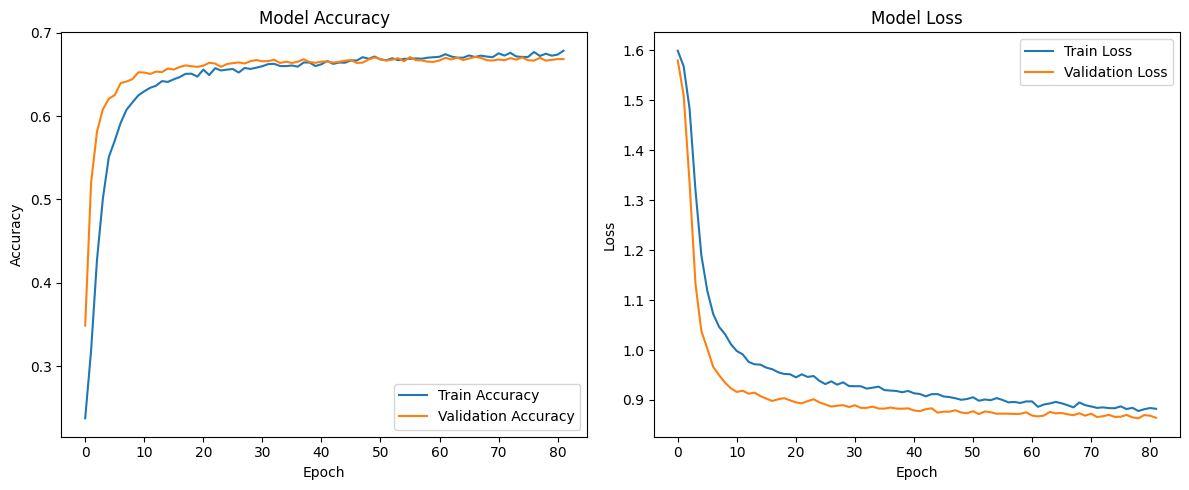

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **Glove Embedding + GRU & LSTM**

#### **Tokenization**

In [ ]:
max_sequence_length = 128
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['Discussion'])
X = tokenizer.texts_to_sequences(df['Discussion'])
X = pad_sequences(X, maxlen=max_sequence_length)

num_classes = len(df['Category'].unique())
y=  df['Category'].values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

word_index = tokenizer.word_index

#### **Embedding**

In [ ]:
def download_glove(url, output_path):

    response = requests.get(url, stream=True)
    with open(output_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"GloVe embeddings downloaded at {output_path}")

def extract_glove(zip_path, extract_to):

    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"GloVe embeddings extracted to {extract_to}")

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_path = "glove.6B.zip"
glove_folder = "glove.6B"

if not os.path.exists(glove_folder):
    download_glove(glove_url, zip_path)
    extract_glove(zip_path, glove_folder)

In [ ]:
def load_glove_embeddings(glove_file, embedding_dim):
    embedding_index = {}
    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    print(f"Loaded {len(embedding_index)} word vectors from {glove_file}")
    return embedding_index

glove_file = os.path.join(glove_folder, "glove.6B.300d.txt")
embedding_dim = 300
embedding_index = load_glove_embeddings(glove_file, embedding_dim)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors from glove.6B/glove.6B.300d.txt


#### **Model Fitting**

In [ ]:

def build_model_glove(
    embedding_matrix,
    nb_words,
    embedding_dim=300,
    max_length=128,
    num_classes=5,
    learning_rate=1e-3,
    l2_reg=1e-4
):
    inp = Input(shape=(max_length,))


    x = Embedding(
        input_dim=nb_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    )(inp)


    x = SpatialDropout1D(0.6)(x)

    x1 = Bidirectional(
        LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
    )(x)


    x2 = Bidirectional(
        GRU(
            128,
            return_sequences=True,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
    )(x1)


    max_pool1 = GlobalMaxPooling1D()(x1)
    max_pool2 = GlobalMaxPooling1D()(x2)

    conc = Concatenate()([max_pool1, max_pool2])


    predictions = Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(conc)

    model = Model(inputs=inp, outputs=predictions)

    # Compile
    model.compile(
        optimizer="adam",
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


embedding_dim = 300
nb_words = len(word_index) + 1

model_glove = build_model_glove(
    embedding_matrix=embedding_matrix,
    nb_words=nb_words,
    embedding_dim=embedding_dim,
    max_length=max_sequence_length,
    num_classes=num_classes,
    learning_rate=1e-3
)

model_glove.summary()





/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 128, 300)       │     22,903,500 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_2       │ (None, 128, 300)       │              0 │ embedding_2[0][0]      │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 128, 256)       │        439,296 │ spatial_dropout1d_2[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 128, 256)       │        296,448 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 256)            │              0 │ bidirectional_4[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_5    │ (None, 256)            │              0 │ bidirectional_5[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 512)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 5)              │          2,565 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,641,809 (90.19 MB)

 Trainable params: 738,309 (2.82 MB)

 Non-trainable params: 22,903,500 (87.37 MB)

In [ ]:
batch_size = 512
epochs = 16

early_stopping_glove = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


callbacks_list_glove = [early_stopping_glove]


history = model_glove.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list_glove,
    class_weight=class_weights_dict,
)

Epoch 1/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 377ms/step - accuracy: 0.4144 - loss: 1.5632 - val_accuracy: 0.6385 - val_loss: 1.0644
Epoch 2/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.6239 - loss: 1.1072 - val_accuracy: 0.6695 - val_loss: 0.9669
Epoch 3/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - accuracy: 0.6509 - loss: 1.0306 - val_accuracy: 0.6792 - val_loss: 0.9375
Epoch 4/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.6517 - loss: 0.9968 - val_accuracy: 0.6834 - val_loss: 0.9232
Epoch 5/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - accuracy: 0.6608 - loss: 0.9761 - val_accuracy: 0.6847 - val_loss: 0.9089
Epoch 6/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.6662 - loss: 0.9547 - val_accuracy: 0.6863 - val_loss: 0.9035
Epoch 7/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.6752 - loss: 0.9364 - val_accuracy: 0.6896 - val_loss: 0.8914
Epoch 8/16
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.6677 - loss: 0.9281 - val_accuracy:

In [ ]:
test_loss, test_accuracy = model_glove.evaluate(X_test, y_test, verbose=1)
train_loss, train_accuracy = model_glove.evaluate(X_train, y_train, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print("-----------------------------------------------------------")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")



142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7085 - loss: 0.8284
568/568 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7447 - loss: 0.7368
Test Loss: 0.8476653099060059
Test Accuracy: 0.7067371010780334
-----------------------------------------------------------
Train Loss: 0.7371604442596436
Train Accuracy: 0.7459399700164795


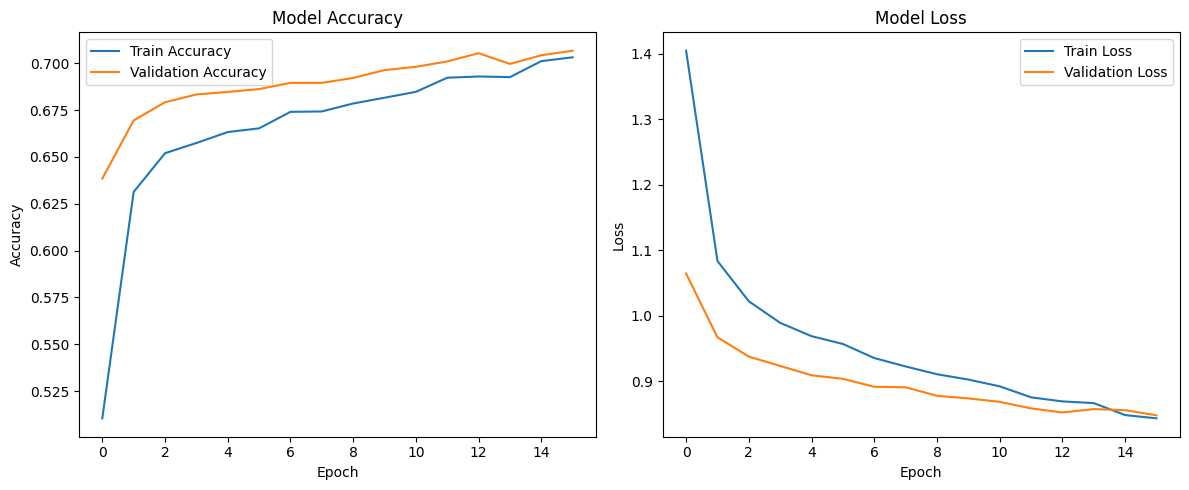

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### **BERT Feature Extraction + Dense**

#### **Tokenization**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_texts(texts, tokenizer, max_length=128):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return encodings['input_ids'], encodings['attention_mask']

max_length = 128
X_input_ids, X_attention_masks = tokenize_texts(df['Discussion'], tokenizer, max_length)

X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    X_input_ids, X_attention_masks, df['Category'].values, test_size=0.2, random_state=42
)

#### **Feature Extraction**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import BertModel

bert_model = BertModel.from_pretrained("bert-base-uncased")

bert_model = bert_model.to(device)

def extract_features_gpu(input_ids, attention_masks, model, batch_size=128):
    features = []
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i + batch_size].to(device)
        batch_attention_masks = attention_masks[i:i + batch_size].to(device)
        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        batch_features = outputs.last_hidden_state[:, 0, :].cpu()
        features.append(batch_features)
    return torch.cat(features, dim=0)

X_train_features = extract_features_gpu(X_train_ids, X_train_masks, bert_model, batch_size=128)
X_test_features = extract_features_gpu(X_test_ids, X_test_masks, bert_model, batch_size=128)

#### **Model Fitting**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


model_bert = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_features.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes
])


model_bert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_bert.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,013 (418.02 KB)

 Trainable params: 107,013 (418.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [early_stopping]

In [ ]:
history = model_bert.fit(
    X_train_features, y_train,
    validation_data=(X_test_features, y_test),
    epochs=100,
    batch_size=1024,
    callbacks=callbacks_list,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.2593 - loss: 1.6829 - val_accuracy: 0.5718 - val_loss: 1.3125
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4586 - loss: 1.3430 - val_accuracy: 0.6297 - val_loss: 1.0491
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5568 - loss: 1.1459 - val_accuracy: 0.6559 - val_loss: 0.9395
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6024 - loss: 1.0465 - val_accuracy: 0.6673 - val_loss: 0.8808
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6316 - loss: 0.9895 - val_accuracy: 0.6695 - val_loss: 0.8688
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6504 - loss: 0.9365 - val_accuracy: 0.6757 - val_loss: 0.8453
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6577 - loss: 0.9317 - val_accuracy: 0.6814 - val_loss: 0.8330
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6729 - loss: 0.8965 - val_accuracy: 0.6841 -

In [ ]:
test_loss1, test_accuracy2 = model_bert.evaluate(X_test_features, y_test, verbose=1)

print(f"Test Loss: {test_loss1}")
print(f"Test Accuracy: {test_accuracy2}")


print("-----------------------------------------------------------")

train_loss3, train_accuracy4 = model_bert.evaluate(X_train_features, y_train, verbose=1)

print(f"Train Loss: {train_loss3}")
print(f"Train Accuracy: {train_accuracy4}")



142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7098 - loss: 0.7700
Test Loss: 0.8011935949325562
Test Accuracy: 0.6996917724609375
-----------------------------------------------------------
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7415 - loss: 0.7025
Train Loss: 0.7037481665611267
Train Accuracy: 0.7385081052780151


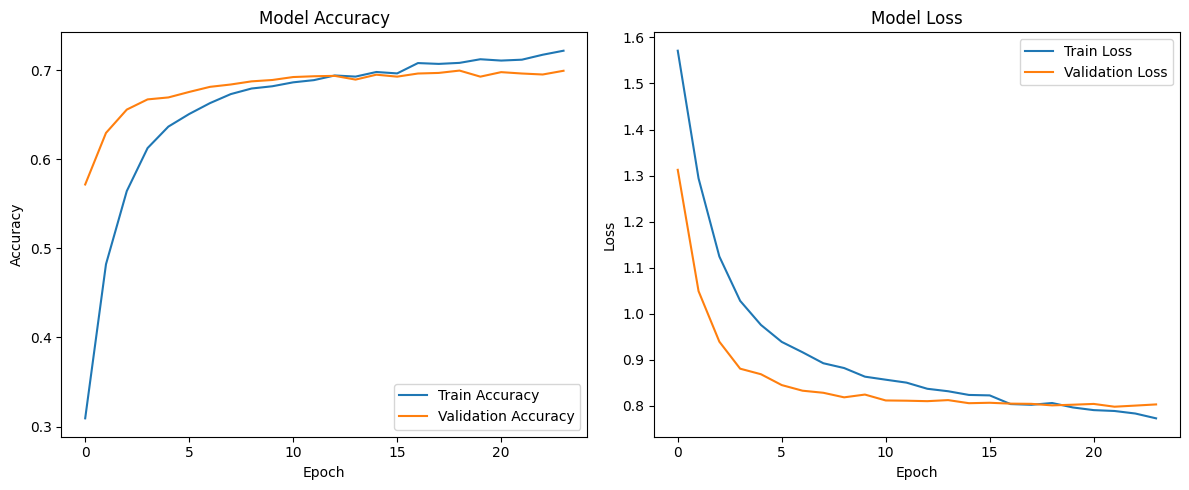

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### **Embedding all-mpnet-base-v2 + Dense**

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

print("\nGenerating embeddings for training data...")
train_embeddings = model.encode(df['Discussion'].tolist(), show_progress_bar=True, convert_to_numpy=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Generating embeddings for training data...


Batches:   0%|          | 0/710 [00:00<?, ?it/s]

In [ ]:
y = df['Category'].values

num_classes = len(category_mapping)

print(f"\nNumber of classes: {num_classes}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")



Number of classes: 5
Class distribution:
4    5134
3    5070
1    4980
0    3910
2    3613
Name: count, dtype: int64


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass Weights: {class_weights_dict}")




Class Weights: {0: 1.1614833759590792, 1: 0.9119277108433735, 2: 1.256960974259618, 3: 0.8957396449704143, 4: 0.8845734320218154}


In [ ]:
from sklearn.model_selection import train_test_split



# Split the data (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    train_embeddings,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Preserves class distribution
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")



Training set size: 18165
Validation set size: 4542


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

def build_feedforward_model_l2(embedding_dim, num_classes, l2_reg=1e-4):
    inputs = layers.Input(shape=(embedding_dim,))

    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


embedding_dim = train_embeddings.shape[1]
num_classes = len(category_mapping)
model_ffn_l2 = build_feedforward_model_l2(embedding_dim, num_classes, l2_reg=1e-4)
model_ffn_l2.summary()

model_ffn_l2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)








Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,405 (900.02 KB)

 Trainable params: 230,405 (900.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)


callbacks_list = [early_stopping]


history = model_ffn_l2.fit(
    X_train,
    np.array(y_train),
    validation_data=(X_val, np.array(y_val)),
    epochs=150,
    batch_size=512,
    callbacks=callbacks_list,
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.2254 - loss: 1.6569 - val_accuracy: 0.5183 - val_loss: 1.6224
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4867 - loss: 1.6088 - val_accuracy: 0.6499 - val_loss: 1.5352
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6243 - loss: 1.5094 - val_accuracy: 0.6843 - val_loss: 1.3754
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6755 - loss: 1.3443 - val_accuracy: 0.7008 - val_loss: 1.1704
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6999 - loss: 1.1502 - val_accuracy: 0.7235 - val_loss: 1.0003
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7167 - loss: 0.9935 - val_accuracy: 0.7285 - val_loss: 0.8979
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7267 - loss: 0.9100 - val_accuracy: 0.7347 - val_loss: 0.8444
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7289 - loss: 0.8702 - val_accuracy: 0.7389 - 

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model_ffn_l2.evaluate(X_val, np.array(y_val), verbose=0)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


print("-----------------------------------------------------------")
train_loss, train_accuracy = model_ffn_l2.evaluate(X_train, np.array(y_train), verbose=0)
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')




Validation Loss: 0.7421
Validation Accuracy: 0.7613
-----------------------------------------------------------
Train Loss: 0.6948
Train Accuracy: 0.7759


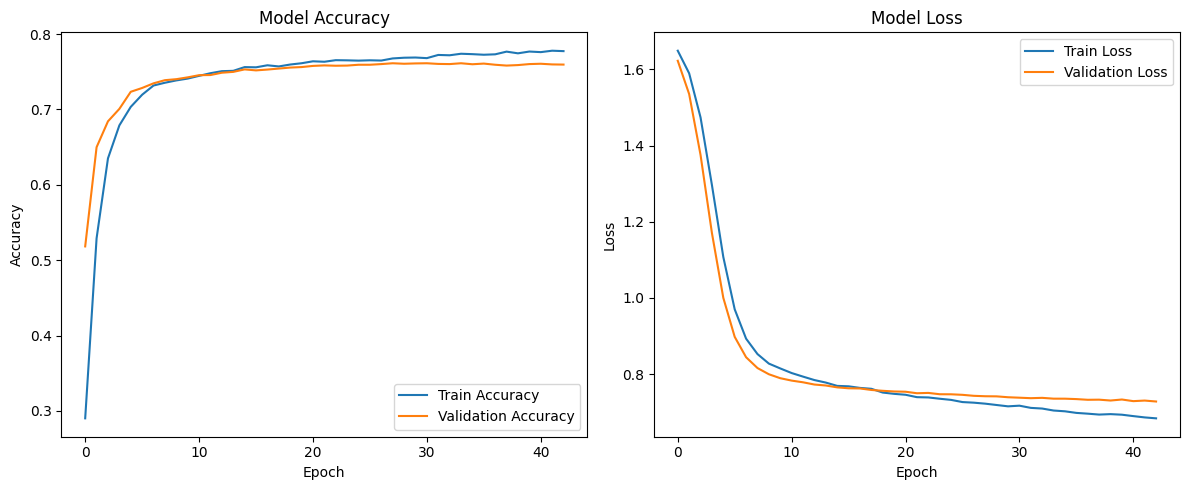

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### **Trasnformers**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')


class TextPreprocessor:

    def extract_features(self, text: str) -> List[float]:

        length = len(text)


        word_count = len(text.split())


        sentence_count = len(nltk.sent_tokenize(text))


        words = text.split()
        avg_word_length = sum(len(word) for word in words) / max(len(words), 1)

        return [length, word_count, sentence_count, avg_word_length]



class TextDataProcessor:
    def __init__(self, model_name: str = 'sentence-transformers/all-roberta-large-v1'):
        self.preprocessor = TextPreprocessor()
        self.encoder = SentenceTransformer(model_name)

    def process_data(self, texts: List[str]) -> np.ndarray:

        cleaned_texts = texts


        print("Generating embeddings...")
        embeddings = self.encoder.encode(cleaned_texts, show_progress_bar=True)

        print("Extracting additional features...")
        additional_features = np.array([self.preprocessor.extract_features(text) for text in texts])


        combined_features = np.concatenate([embeddings, additional_features], axis=1)

        return combined_features




class TextDataset(Dataset):
    def __init__(self, features: np.ndarray, labels: np.ndarray):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self) -> int:
        return len(self.features)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.features[idx], self.labels[idx]




class EnhancedTransformer(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, d_model: int = 256):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)


        self.attention = nn.MultiheadAttention(d_model, num_heads=8, dropout=0.1)
        self.layer_norm2 = nn.LayerNorm(d_model)


        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model * 4, d_model)
        )
        self.layer_norm3 = nn.LayerNorm(d_model)


        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_layer(x)
        x = self.layer_norm1(x)

        x = x.unsqueeze(0)

        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.layer_norm2(x)


        ff_output = self.feed_forward(x)
        x = x + ff_output
        x = self.layer_norm3(x)


        x = x.squeeze(0)
        x = self.classifier(x)

        return x






In [ ]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                num_epochs: int = 50, device: str = 'cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')
            print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')

        scheduler.step()

    return history, all_labels, all_preds

In [ ]:
def plot_metrics(history: dict, labels: list, predictions: list):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()

    print("\nClassification Report:")
    print(classification_report(labels, predictions))

In [ ]:
processor = TextDataProcessor()
features = processor.process_data(df['Discussion'].tolist())

X_train, X_val, y_train, y_val = train_test_split(
    features,
    df['Category'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['Category']
)


train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

input_dim = features.shape[1]
num_classes = len(np.unique(df['Category']))
model = EnhancedTransformer(input_dim, num_classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history, labels, predictions = train_model(model, train_loader, val_loader, device=device)

plot_metrics(history, labels, predictions)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Generating embeddings...


Batches:   0%|          | 0/710 [00:00<?, ?it/s]

Extracting additional features...

Epoch [1/50]
Training Loss: 1.4137, Training Accuracy: 38.74%
Validation Loss: 1.0415, Validation Accuracy: 62.11%
New best model saved with validation accuracy: 62.11%

Epoch [2/50]
Training Loss: 0.9944, Training Accuracy: 62.62%
Validation Loss: 0.9251, Validation Accuracy: 64.84%
New best model saved with validation accuracy: 64.84%

Epoch [3/50]
Training Loss: 0.8566, Training Accuracy: 69.09%
Validation Loss: 0.8799, Validation Accuracy: 67.08%
New best model saved with validation accuracy: 67.08%

Epoch [4/50]
Training Loss: 0.8124, Training Accuracy: 70.26%
Validation Loss: 0.7521, Validation Accuracy: 72.81%
New best model saved with validation accuracy: 72.81%

Epoch [5/50]
Training Loss: 0.7749, Training Accuracy: 71.65%
Validation Loss: 0.7805, Validation Accuracy: 70.87%

Epoch [6/50]
Training Loss: 0.7429, Training Accuracy: 73.04%
Validation Loss: 0.7015, Validation Accuracy: 74.55%
New best model saved with validation accuracy: 74.55%


## **Save The Models**

In [ ]:
model_ffn_l2.save('Dense+Embedding_model.h5') # best
model_bert.save('BERT_model_encode.h5')
model_glove.save('Glove_model.h5')
model_word_2vec.save('Word2Vec_model.h5')
#model_transformers.save('Transformer_model.h5')

In [ ]:
import zipfile
from google.colab import files

zip_filename = 'models.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write('Dense+Embedding_model.h5')
    zipf.write('BERT_model_encode.h5')
    zipf.write('Glove_model.h5')
    zipf.write('Word2Vec_model.h5')

files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>